In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os

# Define the path to the dataset directory
dataset_path = "Dataset_BUSI_with_GT"

# Get the list of image files
image_files = []
labels = []

# Iterate over the directories
for class_name in ['benign', 'malignant', 'normal']:
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image_files.append(image_path)
        labels.append(class_name)

# Convert labels to numerical values
from tensorflow.keras.utils import to_categorical

# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
# Get the original class labels from the label encoder
original_labels = label_encoder.classes_

# Convert labels to one-hot encoded format
labels = to_categorical(labels)


# Print the mapping between numerical values and original labels
for numerical_value, original_label in enumerate(original_labels):
    print(f"Numerical Value: {numerical_value}, Original Label: {original_label}")


Numerical Value: 0, Original Label: benign
Numerical Value: 1, Original Label: malignant
Numerical Value: 2, Original Label: normal


In [6]:
X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.3, random_state=42, stratify=labels)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

1104 1104
474 474


In [7]:
# Define a function to load and preprocess the images
def load_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((150, 150))
#this converts the image to BW
    image = image.convert('L')
    image = np.array(image)
    image = image.reshape((150, 150, 1))
#image normalization
    image = image.astype('float32') / 255.0
    return image

X_train = [str(image_path) for image_path in X_train]
X_test = [str(image_path) for image_path in X_test]

# Load and preprocess the training images and labels
X_train = [load_preprocess_image(image_path) for image_path in X_train]
X_train = np.array(X_train)
y_train= np.array(y_train)

# Load and preprocess the testing images and labels
X_test= [load_preprocess_image(image_path) for image_path in X_test]
X_test = np.array(X_test)
y_test = np.array(y_test)

(1104, 150, 150, 1) (1104, 3)
(474, 150, 150, 1) (474, 3)


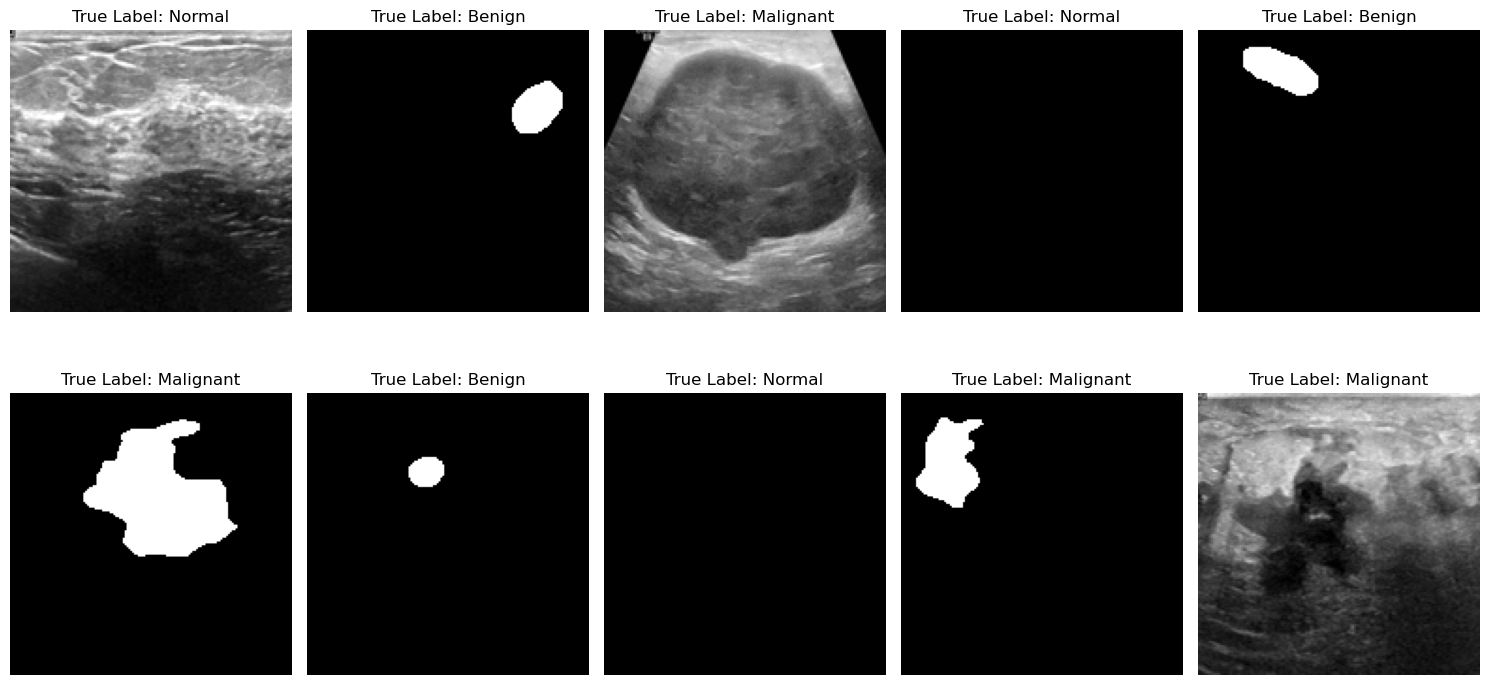

In [8]:
#Check size and color channels of images and labels
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

#Show images
images = X_test[:10]  # Assuming X_test contains the image data
labels = y_test[:10]  # Assuming y_test contains the corresponding labels

# Convert them to class indices
class_indices = np.argmax(labels, axis=1)

# Define class labels
class_labels = ['Benign', 'Malignant', 'Normal']

num_rows = 2
num_cols = len(images) // num_rows

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Display images with labels in the subplots
for i in range(len(images)):
    ax = axes[i]
    ax.imshow(images[i], cmap='gray')  # Assuming images are 2D arrays (grayscale)
    ax.set_title(f'True Label: {class_labels[class_indices[i]]}')
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [9]:
from tensorflow.image import resize

# Resize input images to match model's input shape (128x128)
X_train_resized = resize(X_train, [128, 128])
X_test_resized = resize(X_test, [128, 128])

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add more convolutional layers
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add additional convolutional layers
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback to monitor accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)



In [11]:
# Train the model
#model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5142 - loss: 1.1306 - val_accuracy: 0.5766 - val_loss: 0.8255
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5809 - loss: 0.8449 - val_accuracy: 0.5856 - val_loss: 0.8486
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5458 - loss: 0.9411 - val_accuracy: 0.6396 - val_loss: 0.7604
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6667 - loss: 0.7731 - val_accuracy: 0.7207 - val_loss: 0.6928
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6453 - loss: 0.7574 - val_accuracy: 0.6847 - val_loss: 0.6931
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6863 - loss: 0.6757 - val_accuracy: 0.7027 - val_loss: 0.7061
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7010 - loss: 0.6489 - val_accuracy: 0.7477 - val_loss: 0.5851
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7015 - loss: 0.5786 - val_accuracy: 0.7027 - val_loss:

In [12]:
# Serialize model architecture to JSON
model_json = model.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model_new_weights.weights.h5")


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,247,563 (31.46 MB)

 Trainable params: 2,749,187 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,498,376 (20.97 MB)

In [14]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print('Training Accuracy:', train_accuracy,"Train loss",train_loss)
print('Testing Accuracy:', test_accuracy,"Test Loss",test_loss)

Training Accuracy: 0.9112318754196167 Train loss 0.2570047378540039
Testing Accuracy: 0.8438818454742432 Test Loss 0.411266028881073


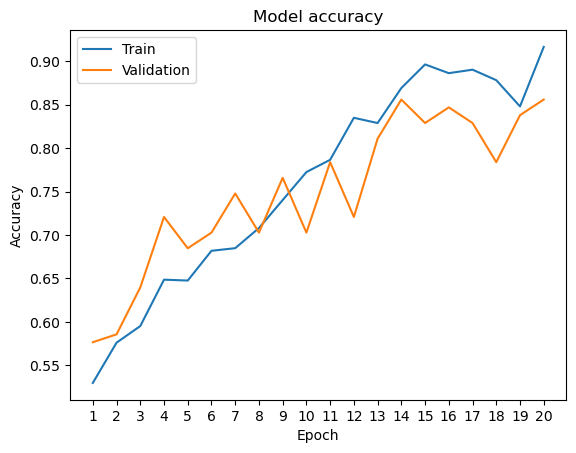

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# Generate x-axis values as integers
epochs = np.arange(1, len(history.history['accuracy']) + 1)

# Plotting
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, len(epochs) + 1, 1))  # Set x-ticks at every other integer value
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

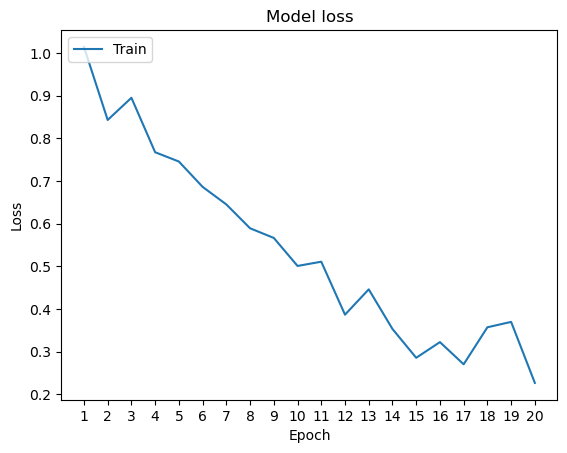

In [26]:
# Plot training & validation loss values
plt.plot(epochs, history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1, len(epochs) + 1, 1))  # Set x-ticks at every other integer value
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Flatten the image data for kNN
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define and train the kNN classifier
k = 5  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_flat, y_train)

# Predict labels for test data
y_pred = knn_classifier.predict(X_test_flat)

# Evaluate the classifier
accuracy = knn_classifier.score(X_test_flat, y_test)
print("Accuracy of kNN classifier:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Convert one-hot encoded labels back to categorical labels
y_test_categorical = np.argmax(y_test, axis=1)
predictions_categorical = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_categorical, predictions_categorical)

# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the image data for kNN
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define and train your model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_flat, y_train)

# Make predictions on the test set
predictions = model_rf.predict(X_test_flat)

# Assess the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy = ", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Convert one-hot encoded labels back to categorical labels
y_test_categorical = np.argmax(y_test, axis=1)
predictions_categorical = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_categorical, predictions_categorical)

# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
